In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py, os

import tensorflow as tf
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices(device_type="GPU")[0], True)
from deepsphere.healpy_layers import HealpySmoothing

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

from tqdm import tqdm
from icecream import ic
from scipy.stats import binned_statistic

from msfm.grid_pipeline import GridPipeline
from msfm.fiducial_pipeline import FiducialPipeline
from msfm.utils import logger, input_output, files, scales, power_spectra, parameters

from deep_lss.utils import configuration

from msi.utils import preprocessing, dataset

In [3]:
msfm_conf = files.load_config("/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v10/linear_bias.yaml")
base_dir = "/pscratch/sd/a/athomsen/v11desy3/v10/linear_bias"

# for the white noise level
dlss_conf = configuration.load_deep_lss_config("/global/u2/a/athomsen/y3-deep-lss/configs/v10/combined/dlss_config.yaml")

with_cross_z = False
with_white_noise = True

24-09-27 00:39:50 configuratio INF   Loaded the config 


In [4]:
with_lensing = True
with_clustering = False
params = ["Om", "s8", "w0", "Aia", "n_Aia"]

In [5]:
# with_lensing = False
# with_clustering = True
# params = ["Om", "s8", "w0", "bg", "n_bg"]

In [6]:
# with_lensing = True
# with_clustering = True
# params = ["Om", "s8", "w0", "Aia", "n_Aia", "bg", "n_bg"]

# white noise dset

24-09-27 00:39:52 configuratio INF   Loaded the config 
24-09-27 00:39:52 preprocessin INF   Using theta_fwhm = [22.1, 15.1, 11.2, 9.4, 65.1, 44.5, 34.1, 28.5] from the dlss config 
24-09-27 00:39:52 preprocessin INF   Using white_noise_sigma = [0.000231902835, 0.000308982676, 0.000417579788, 0.00100304068, 0.520092784, 0.206405445, 0.149487804, 0.13530551] from the dlss config 
24-09-27 00:39:52 preprocessin INF   Using l_maxs = [ 488.68778281  715.23178808  964.28571429 1148.93617021  165.89861751
  242.69662921  316.71554252  378.94736842] from the dlss config 
24-09-27 00:39:52 preprocessin INF   Using l_mins = [0. 0. 0. 0. 0. 0. 0. 0.] by default (no smoothing) 
24-09-27 00:39:52 preprocessin INF   Using n_bins = 33 from the msfm config 
24-09-27 00:39:52 preprocessin INF   Loading the pre-binned Cls 
24-09-27 00:39:52 input_output INF   Loading summaries from /pscratch/sd/a/athomsen/v11desy3/v10/linear_bias 
24-09-27 00:39:52 input_output INF   Array shapes: 
24-09-27 00:39:52 in

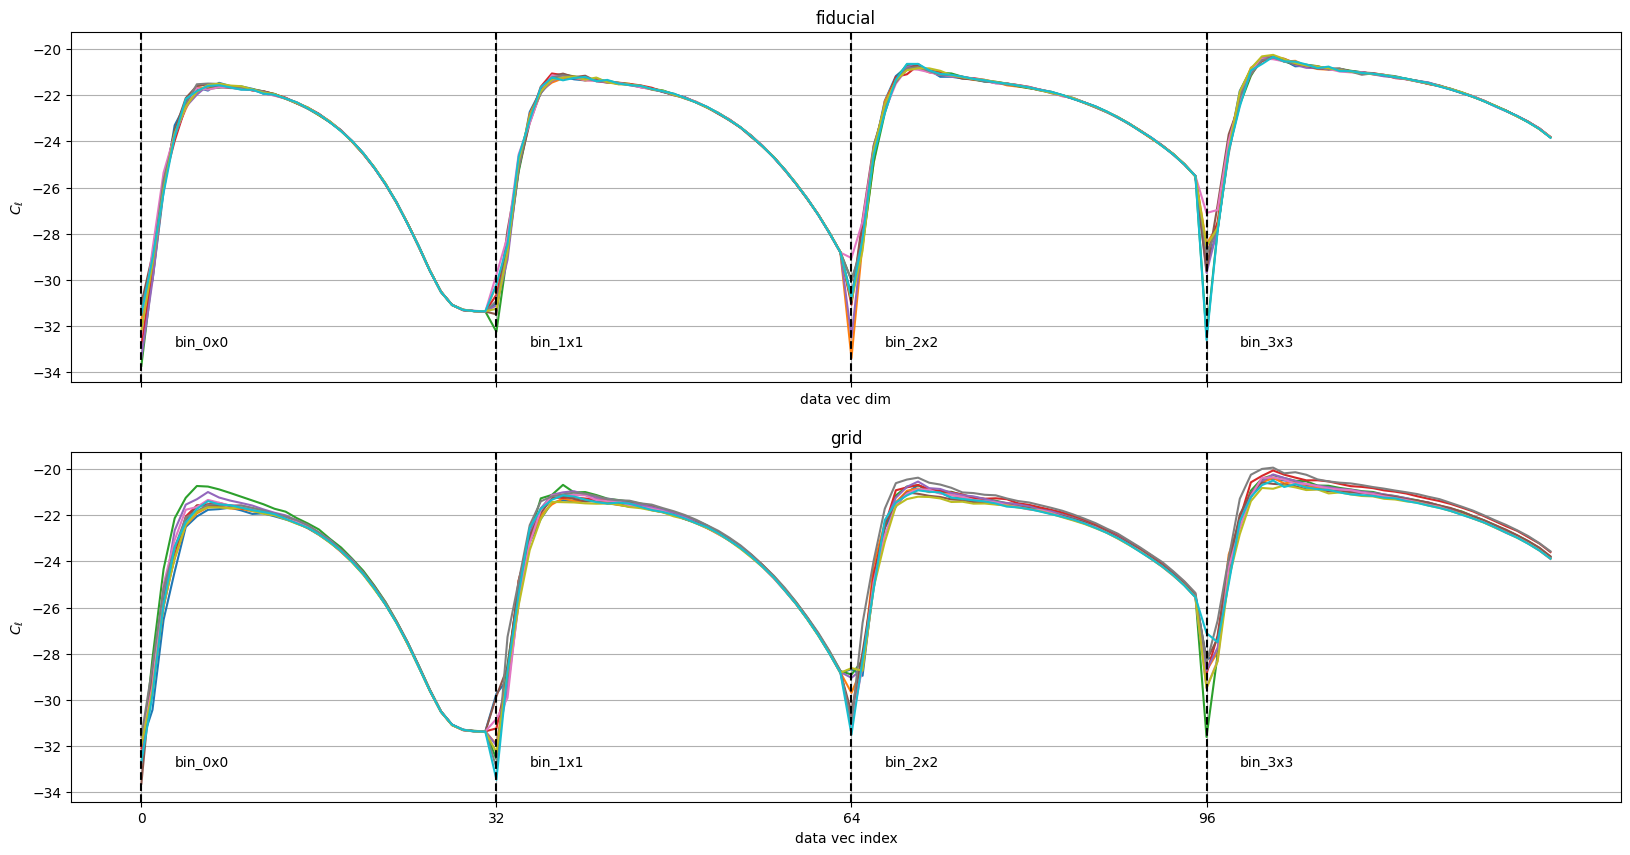

In [7]:
cl_dset_train, cl_dset_test, out_dict = dataset.get_binned_power_spectra_dset(
    base_dir, 
    # configuration
    msfm_conf=msfm_conf,
    dlss_conf=dlss_conf,
    params=params,
    # selection
    with_lensing=with_lensing,
    with_clustering=with_clustering,
    with_cross_z=with_cross_z,
    with_gaussian_noise=with_white_noise,
    # l_mins=4*[None],
    # l_maxs=4*[None],
    # preprocessing
    # apply_log=False,
    cls_from_maps=False,
)

24-09-27 00:40:16 configuratio INF   Loaded the config 
24-09-27 00:40:16 preprocessin INF   Using theta_fwhm = [22.1, 15.1, 11.2, 9.4, 65.1, 44.5, 34.1, 28.5] from the dlss config 
24-09-27 00:40:16 preprocessin INF   Using white_noise_sigma = [0.000231902835, 0.000308982676, 0.000417579788, 0.00100304068, 0.520092784, 0.206405445, 0.149487804, 0.13530551] from the dlss config 
24-09-27 00:40:16 preprocessin INF   Using l_maxs = [ 488.68778281  715.23178808  964.28571429 1148.93617021  165.89861751
  242.69662921  316.71554252  378.94736842] from the dlss config 
24-09-27 00:40:16 preprocessin INF   Using l_mins = [0. 0. 0. 0. 0. 0. 0. 0.] by default (no smoothing) 
24-09-27 00:40:16 preprocessin INF   Using n_bins = 33 from the msfm config 
24-09-27 00:40:16 preprocessin INF   Loading the pre-binned Cls 
24-09-27 00:40:16 input_output INF   Loading summaries from /pscratch/sd/a/athomsen/v11desy3/v10/linear_bias 
24-09-27 00:40:16 input_output INF   Array shapes: 
24-09-27 00:40:16 in

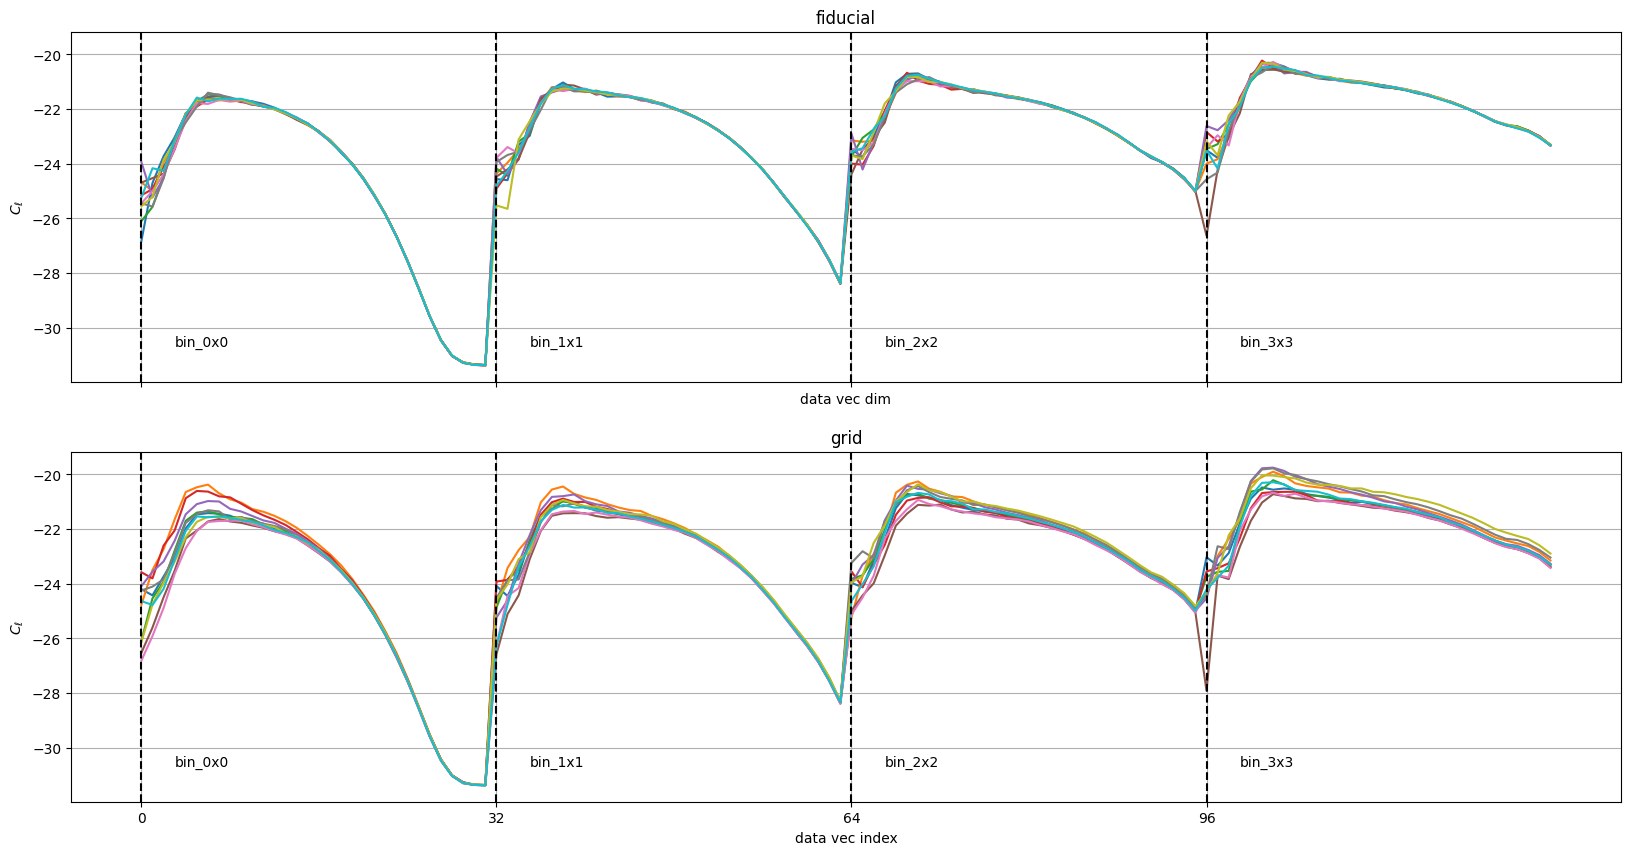

In [8]:
cl_dset_train, cl_dset_test, out_dict = dataset.get_binned_power_spectra_dset(
    base_dir, 
    # configuration
    msfm_conf=msfm_conf,
    dlss_conf=dlss_conf,
    params=params,
    # selection
    with_lensing=with_lensing,
    with_clustering=with_clustering,
    with_cross_z=with_cross_z,
    with_gaussian_noise=with_white_noise,
    # l_mins=4*[None],
    # l_maxs=4*[None],
    # preprocessing
    # apply_log=False,
    cls_from_maps=True,
)

# maps directly

In [8]:
# tfr_pattern = "/pscratch/sd/a/athomsen/v11desy3/v10/linear_bias/tfrecords/fiducial/DESy3_fiducial_dmb_0513.tfrecord"

# no masking after smoothing the maps
tfr_pattern = "/pscratch/sd/a/athomsen/v11desy3/v10/linear_bias/tfrecords/fiducial/debug/DESy3_fiducial_dmb_0000.tfrecord"

In [9]:
pipe = FiducialPipeline(
    conf=msfm_conf,
    params=[],
    with_lensing=with_lensing,
    with_clustering=with_clustering,
    with_padding=True,
    apply_norm=False,
)

dset = pipe.get_dset(
    tfr_pattern=tfr_pattern,
    local_batch_size=1,
    noise_indices=1,
    n_readers=1,
    examples_shuffle_buffer=None,
    n_prefetch=0,
    is_eval=True,
)

n_side = 512
n_pix = hp.nside2npix(n_side)

params = pipe.params
n_params = len(params)
n_maps = 2 * len(params) + 1 
n_noise = 2
data_vec_pix = pipe.data_vec_pix
n_z = pipe.n_z_metacal + pipe.n_z_maglim
n_z_metacal = pipe.n_z_metacal

24-09-25 02:06:25     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_fiducial_512.h5 
24-09-25 02:06:25     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_fiducial_512.h5 
24-09-25 02:06:26 fiducial_pip WAR   Evaluation mode is activated: the random seed is fixed, the shuffle arguments ignored, and the dataset is not repeated 
24-09-25 02:06:26 fiducial_pip INF   n_workers is not set, using tf.data.AUTOTUNE. This might produce unexpected RAM usage. 
24-09-25 02:06:26 fiducial_pip INF   drop_remainder is not set, using drop_remainder = False 
24-09-25 02:06:26 fiducial_pip INF   Including noise_indices = [0] 
24-09-25 02:06:26 fiducial_pip INF   Interleaving with n_readers = 1 
24-09-25 02:06:27 fiducial_pip INF   Batching into 1 elements locally with drop_remainder = False 
24-09-25 02:06:28 fiducial_pip WAR   Tracing _augmentations 
Please report 

In [10]:
smoothing_kwargs = {
    "nside": n_side,
    "indices": data_vec_pix,
    "nest": True,
    "n_sigma_support": dlss_conf["scale_cuts"]["n_sigma_support"],
    "arcmin": dlss_conf["scale_cuts"]["arcmin"],
    "data_path": ".",
}
mask_dict = files.get_tomo_dv_masks(msfm_conf)

fwhm = []
white_noise_sigma = []
mask = []
if with_lensing:
    fwhm += dlss_conf["scale_cuts"]["lensing"]["theta_fwhm"]
    white_noise_sigma += dlss_conf["scale_cuts"]["lensing"]["white_noise_sigma"]
    mask += [mask_dict["metacal"]]
if with_clustering:
    fwhm += dlss_conf["scale_cuts"]["clustering"]["theta_fwhm"]
    white_noise_sigma += dlss_conf["scale_cuts"]["clustering"]["white_noise_sigma"]
    mask += [mask_dict["maglim"]]
smoothing_kwargs["fwhm"] = fwhm
if with_white_noise:
    smoothing_kwargs["white_noise_sigma"] = white_noise_sigma
smoothing_kwargs["mask"] = np.concatenate(mask, axis=1)

noisy_smoothing_layer = tf.function(HealpySmoothing(**smoothing_kwargs))

24-09-25 02:06:30     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_fiducial_512.h5 
Using the per channel smoothing repetitions [6 3 2 1]
Using the per channel smoothing scales sigma = [29.65 20.96 17.12 12.1 ] arcmin, fwhm = [69.81 49.36 40.31 28.5 ] arcmin
Successfully loaded sparse kernel indices and values from .
Successfully created the sparse kernel tensor
Adding white noise with sigma ListWrapper([0.520092784, 0.206405445, 0.149487804, 0.13530551]) to the smoothed map. Note that networks outputs are nondeterministic, even for training=False


Successfully built the smoothing layer


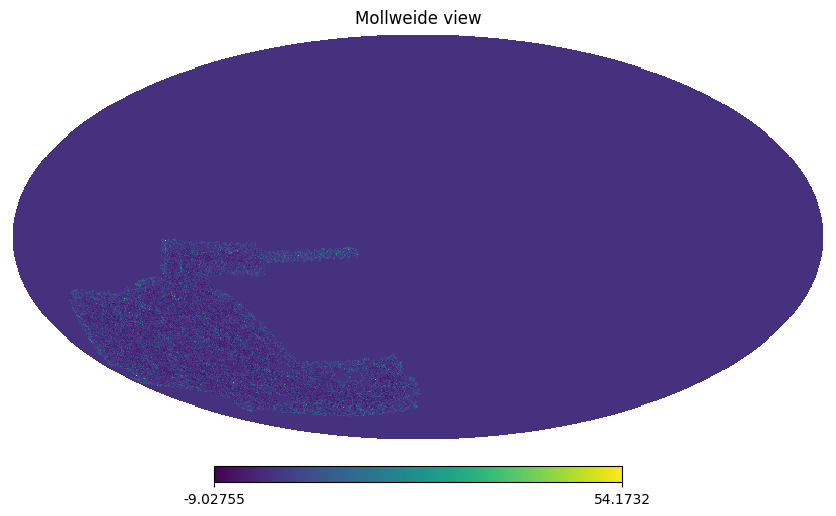

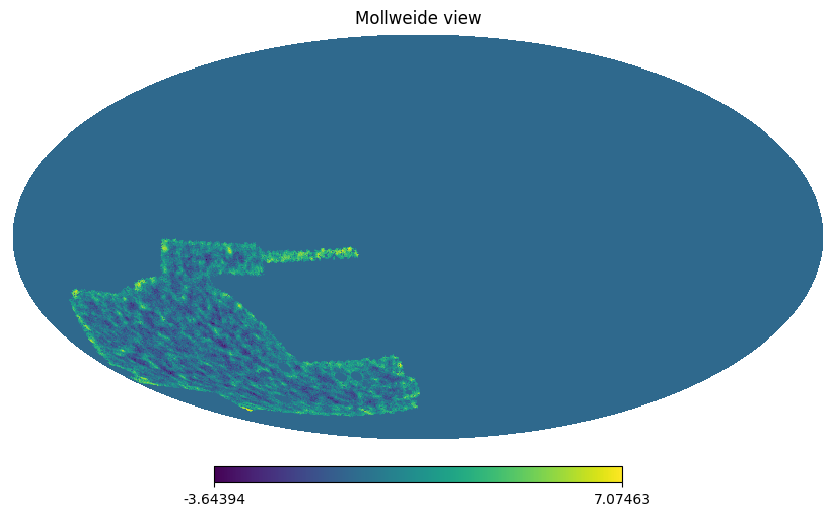

In [11]:
i_z = 0

for dv, tfr_cls, index in dset.take(1):
    tfr_cls = np.squeeze(tfr_cls.numpy())
    
    map_raw = np.zeros((n_pix, dv.shape[-1]))
    map_raw[data_vec_pix] = dv[0]

    smoothed_dv = noisy_smoothing_layer(dv)
    map_smoothed = np.zeros((n_pix, smoothed_dv.shape[-1]))
    map_smoothed[data_vec_pix] = smoothed_dv[0]
    
hp.mollview(map_raw[:,i_z], nest=True)
hp.mollview(map_smoothed[:,i_z], nest=True)

In [12]:
# map_alms = power_spectra.get_alms(map_smoothed, nest=True)
map_alms = power_spectra.get_alms(map_raw, nest=True)
map_cls = power_spectra.get_cls(map_alms, with_cross=with_cross_z)

ells = np.arange(0, 3 * msfm_conf["analysis"]["n_side"])
bins = power_spectra.get_cl_bins(
    msfm_conf["analysis"]["power_spectra"]["l_min"],
    msfm_conf["analysis"]["power_spectra"]["l_max"],
    msfm_conf["analysis"]["power_spectra"]["n_bins"],
)

binned_map_cls = []
binned_tfr_cls = []
for i in range(map_cls.shape[-1]):
    binned_map_cls.append(binned_statistic(ells, map_cls[:,i], statistic="mean", bins=bins)[0])  
    binned_tfr_cls.append(binned_statistic(ells, tfr_cls[:,i], statistic="mean", bins=bins)[0])  
binned_map_cls = np.stack(binned_map_cls, axis=-1)
binned_tfr_cls = np.stack(binned_tfr_cls, axis=-1)

binned_map_cls = np.concatenate([binned_map_cls[..., i] for i in range(binned_map_cls.shape[-1])], axis=-1)
binned_tfr_cls = np.concatenate([binned_tfr_cls[..., i] for i in range(binned_tfr_cls.shape[-1])], axis=-1)

# comparison

[None]

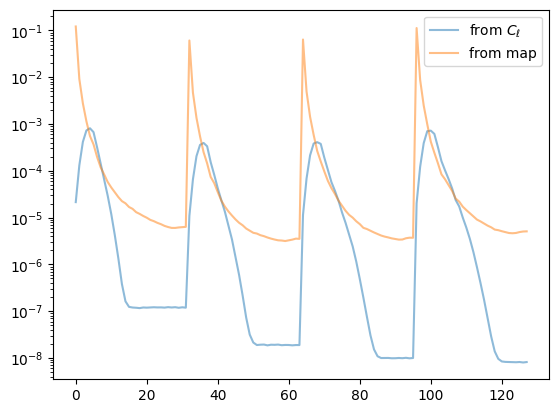

In [13]:
cls_ex = out_dict["fidu/cls"][0,:]
map_ex = binned_map_cls
tfr_ex = binned_tfr_cls

fig, ax = plt.subplots()

ax.plot(cls_ex, label=r"from $C_\ell$", alpha=0.5)
ax.plot(map_ex, label="from map", alpha=0.5)
# ax.plot(tfr_ex, label="from tfr", alpha=0.5)

ax.legend(loc="best")
ax.set(yscale="log")

[None]

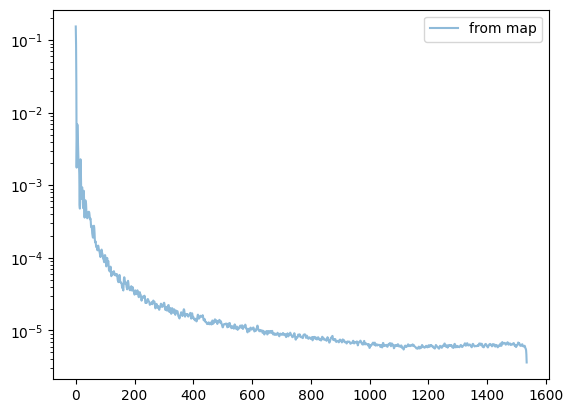

In [14]:
i_z = 0

# cls_ex = out_dict["fidu/cls"][0,:]
map_ex = map_cls[:,i_z]

fig, ax = plt.subplots()

# ax.plot(cls_ex, label=r"from $C_\ell$", alpha=0.5)
ax.plot(map_ex, label="from map", alpha=0.5)

ax.legend(loc="best")
ax.set(yscale="log")

# debug

In [15]:
from msfm.utils import cross_statistics
from msi.utils import input_output

In [16]:
cls_dict = input_output.load_human_summaries(
    base_dir, "cls", return_raw_cls=True, return_fiducial=True, return_grid=False
)

24-09-25 02:06:42 input_output WAR   Returning the raw Cls, this is potentially slow 
24-09-25 02:06:42 input_output INF   Array shapes: 
24-09-25 02:06:42 input_output INF   fiducial/i_example = (35920,) 
24-09-25 02:06:42 input_output INF   fiducial/i_noise   = (35920,) 
24-09-25 02:06:42 input_output INF   fiducial/cls/binned = (35920, 32, 36) 
24-09-25 02:06:42 input_output INF   fiducial/cls/bin_edges = (33, 36) 
24-09-25 02:06:46 input_output INF   fiducial/cls/raw   = (35920, 1536, 36) 
24-09-25 02:06:46 input_output INF   Done loading the summaries after 0:00:04.04 


In [17]:
# bin_indices, bin_names = cross_statistics.get_cross_bin_indices(
#     with_lensing=with_lensing,
#     with_clustering=with_clustering,
#     with_cross_z=with_cross_z,
# )

(35920, 400)


[None]

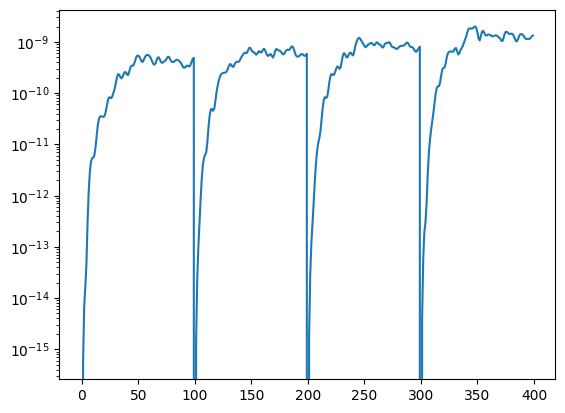

In [18]:
bin_indices, bin_names = cross_statistics.get_cross_bin_indices(
    with_lensing=True,
    with_clustering=False,
    with_cross_z=with_cross_z,
)

fidu_cls = cls_dict["fiducial/cls/raw"]
fidu_cls = fidu_cls[..., bin_indices]
fidu_cls = fidu_cls[:, :100, :]
fidu_cls = np.concatenate([fidu_cls[..., i] for i in range(fidu_cls.shape[-1])], axis=-1)
print(fidu_cls.shape)

fig, ax = plt.subplots()
ax.plot(fidu_cls[0])
ax.set(yscale="log")

(35920, 400)


[None]

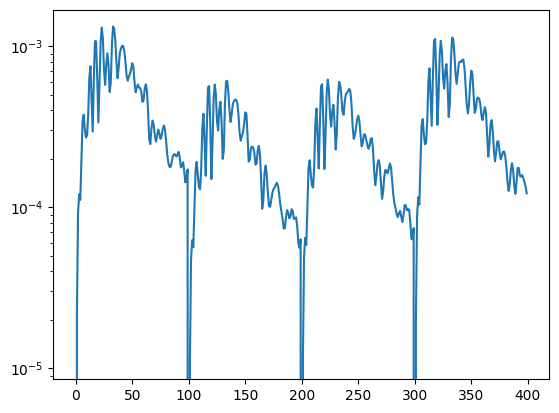

In [19]:
bin_indices, bin_names = cross_statistics.get_cross_bin_indices(
    with_lensing=False,
    with_clustering=True,
    with_cross_z=with_cross_z,
)

fidu_cls = cls_dict["fiducial/cls/raw"]
fidu_cls = fidu_cls[..., bin_indices]
fidu_cls = fidu_cls[:, :100, :]
fidu_cls = np.concatenate([fidu_cls[..., i] for i in range(fidu_cls.shape[-1])], axis=-1)
print(fidu_cls.shape)

fig, ax = plt.subplots()
ax.plot(fidu_cls[0])
ax.set(yscale="log")

In [7]:
grid_file = "/pscratch/sd/a/athomsen/v11desy3/v10/linear_bias/cls/grid_cls_from_maps_001026.h5"
with h5py.File(grid_file, "r") as f:
    print(f.keys())
    grid_cls = f["cls/binned"][:]

<KeysViewHDF5 ['cls', 'cosmo', 'i_example', 'i_noise', 'i_sobol']>


[None]

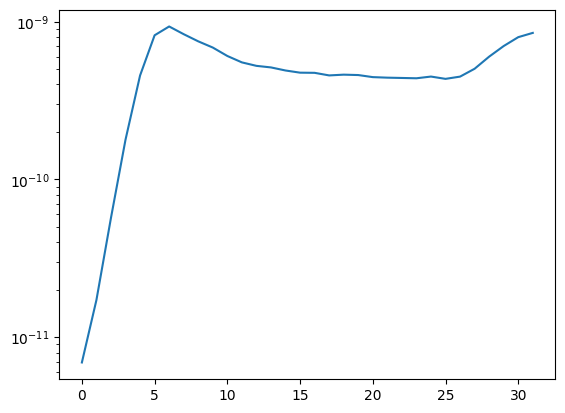

In [10]:
i_z = 0
# i_z = 26

fig, ax = plt.subplots()
ax.plot(grid_cls[0,:,i_z])
ax.set(yscale="log")

# smooth a masked galaxy clustering map

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import h5py, os

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

from tqdm import tqdm

from msfm.grid_pipeline import GridPipeline
from msfm.utils import logger, input_output, files, scales, power_spectra, parameters, clustering, redshift

In [16]:
conf = "/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v10/linear_bias.yaml"
conf = files.load_config(conf)
hp_datapath = "/global/u2/a/athomsen/multiprobe-simulation-forward-model/data/healpy_data"

n_side = conf["analysis"]["n_side"]
n_pix = conf["analysis"]["n_pix"]
l_min_global = 20
l_max_global = 1535
data_vec_pix, patches_pix_dict, corresponding_pix_dict, _ = files.load_pixel_file(conf)
patch_pix = patches_pix_dict["metacal"][0][0]

# fiducial values
Aia = conf["analysis"]["fiducial"]["Aia"]
n_Aia = conf["analysis"]["fiducial"]["n_Aia"]

bg = conf["analysis"]["fiducial"]["bg"]
n_bg = conf["analysis"]["fiducial"]["n_bg"]

z0 = conf["analysis"]["modelling"]["z0"]

# metacal
metacal_bins = conf["survey"]["metacal"]["z_bins"]
n_z_metacal = len(metacal_bins)
tomo_z_metacal, tomo_nz_metacal = files.load_redshift_distributions("metacal", conf)
tomo_Aia = redshift.get_tomo_amplitudes(Aia, n_Aia, tomo_z_metacal, tomo_nz_metacal, z0)

# maglim
maglim_bins = conf["survey"]["metacal"]["z_bins"]
n_z_maglim = len(maglim_bins)
tomo_z_maglim, tomo_nz_maglim = files.load_redshift_distributions("maglim", conf)
tomo_n_gal_maglim = np.array(conf["survey"]["maglim"]["n_gal"]) * hp.nside2pixarea(n_side, degrees=True)
tomo_bg = redshift.get_tomo_amplitudes(bg, n_bg, tomo_z_maglim, tomo_nz_maglim, z0)

n_z = n_z_metacal + n_z_maglim

# numpy
rng = np.random.default_rng(12)

24-09-26 07:33:26     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_fiducial_512.h5 


In [15]:
%%time
# fidu_dir = "/global/cfs/cdirs/des/cosmogrid/v11desy3/fiducial/cosmo_fiducial"
# fidu_dir = "/pscratch/sd/a/athomsen/v11desy3/fiducial/cosmo_fiducial"
fidu_dir = "/global/cfs/cdirs/des/cosmogrid/v11desy3/CosmoGrid/v11desy3/fiducial/cosmo_fiducial"

n_examples = 1

wl = []
gc = []
for i in tqdm(range(n_examples)):
    with h5py.File(os.path.join(fidu_dir, f"perm_{i:04d}", "projected_probes_maps_v11dmb.h5"), "r") as f:
        kg = []
        ia = []
        for z_bin in metacal_bins:
            kg.append(hp.ud_grade(f[f"map/kg/{z_bin}"], n_side))
            ia.append(hp.ud_grade(f[f"map/ia/{z_bin}"], n_side))
        kg = np.stack(kg, axis=-1)
        ia = np.stack(ia, axis=-1)
        
        wl.append(kg + tomo_Aia * ia)

        dg = []
        for z_bin in maglim_bins:
            dg.append(hp.ud_grade(f[f"map/dg/{z_bin}"], n_side))
        dg = np.stack(dg, axis=-1)
        
        gc.append(clustering.galaxy_density_to_count(tomo_n_gal_maglim, (dg - np.mean(dg))/np.mean(dg), tomo_bg, nest=False))

wl = np.stack(wl, axis=0)
gc = np.stack(gc, axis=0)

fidu_maps = np.concatenate([wl, gc], axis=-1)

print(fidu_maps.shape)

100%|██████████| 1/1 [01:07<00:00, 67.63s/it]

(1, 3145728, 8)
CPU times: user 55.9 s, sys: 11.5 s, total: 1min 7s
Wall time: 1min 7s


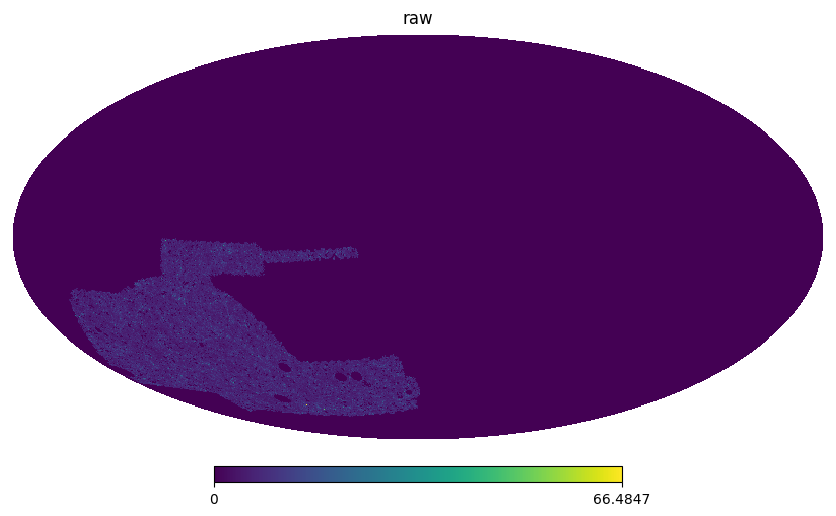

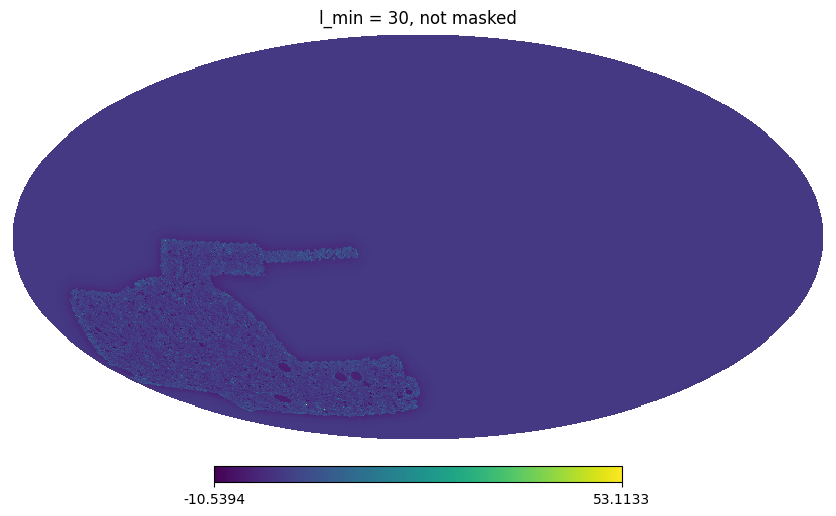

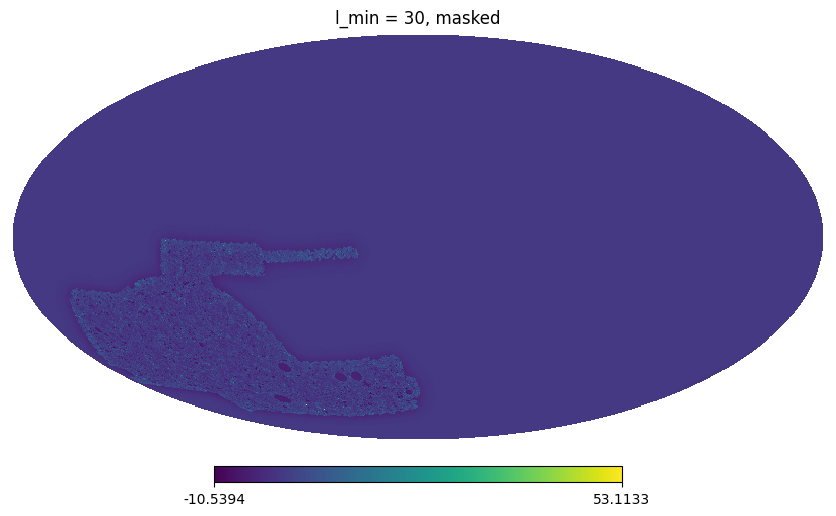

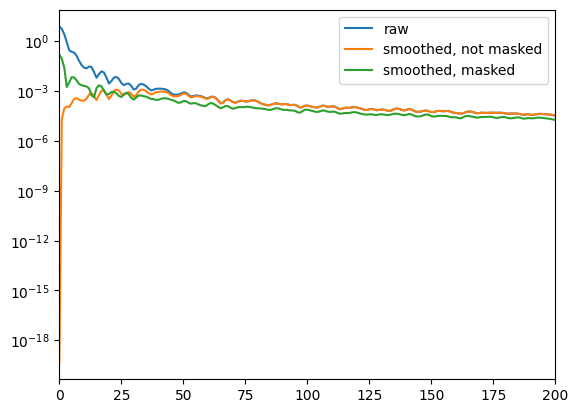

In [34]:
i_z = 0

# raw
gc_patch = np.zeros(n_pix)
gc_patch[patch_pix] = gc[0, patch_pix, i_z]
alm_patch = hp.anafast(gc_patch)

hp.mollview(gc_patch, nest=False, title="raw")

# large scales removed
l_min = 30
gc_patch_smooth, alm_patch_smooth = scales.map_to_smoothed_map(
    gc_patch,
    n_side=n_side,
    l_min=l_min,
    nest=False,
    conf=conf,
)
alm_patch_smooth = hp.anafast(gc_patch_smooth)

hp.mollview(gc_patch_smooth, nest=False, title=f"l_min = {l_min}, not masked")

gc_patch_masked = gc_patch_smooth.copy()
gc_patch_masked[np.setdiff1d(np.arange(gc_patch_masked.shape[0]), patch_pix)] = 0
alm_patch_masked = hp.anafast(gc_patch_masked)

hp.mollview(gc_patch_smooth, nest=False, title=f"l_min = {l_min}, masked")

fig, ax = plt.subplots()

ax.plot(alm_patch, label="raw")
ax.plot(alm_patch_smooth, label="smoothed, not masked")
ax.plot(alm_patch_masked, label="smoothed, masked")

ax.set(yscale="log", xlim=(0, 200))
ax.legend()